In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns


data = pd.read_csv('insurance.csv')

data.head()



age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [2]:
categorical_features = ['gender', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), categorical_features)
    ]
)

In [3]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('regressor', RandomForestRegressor())
])

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('rfe', RFE(estimator=LinearRegression(), n_features_to_select=5)),
    ('regressor', LinearRegression())
])

In [4]:
param_grid_rf = {
    'pca__n_components': [3, 5, 7],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20]
}

param_grid_lr = {
    'rfe__n_features_to_select': [3, 5, 7]
}

In [5]:
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, n_jobs=-1)
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, n_jobs=-1)

In [6]:
grid_rf.fit(data.drop('insurance_cost', axis=1), data['insurance_cost'])

grid_lr.fit(data.drop('insurance_cost', axis=1), data['insurance_cost'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('dim_red',
                                        RFE(estimator=LinearRegression(),
                                            n_features_to_select=5)),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1,
             param_grid={'dim_red__n_features_to_select': [3, 5, 7]})

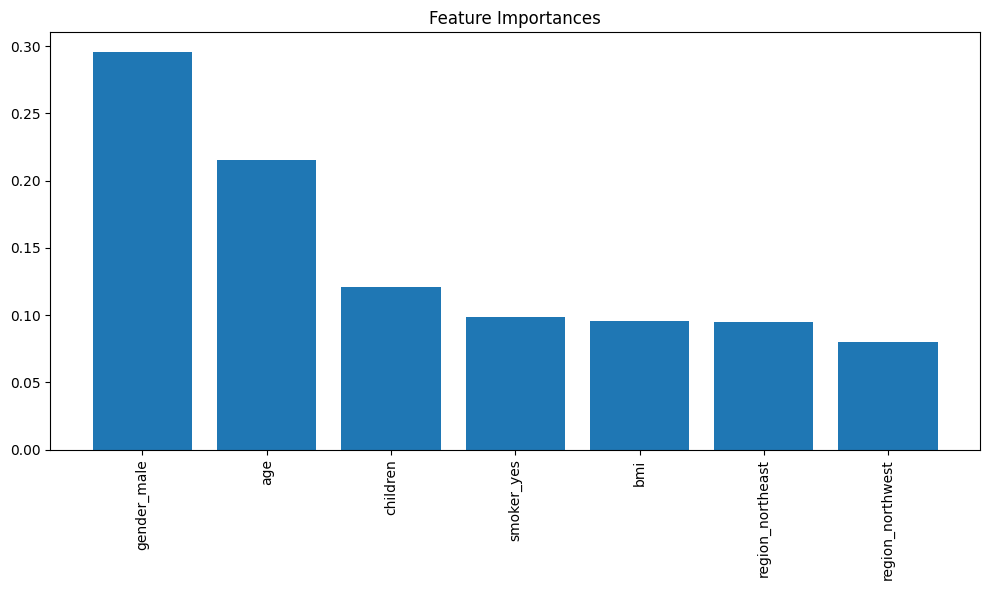

In [7]:
def plot_feature_importance(model):
    feature_importances = model.named_steps['regressor'].feature_importances_
    features = np.array(numerical_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()))
    indices = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), feature_importances[indices], align='center')
    plt.xticks(range(len(indices)), features[indices], rotation=90)
    plt.tight_layout()
    plt.show()

plot_feature_importance(grid_rf.best_estimator_)

In [8]:
X = data.drop('insurance_cost', axis=1)
y = data['insurance_cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

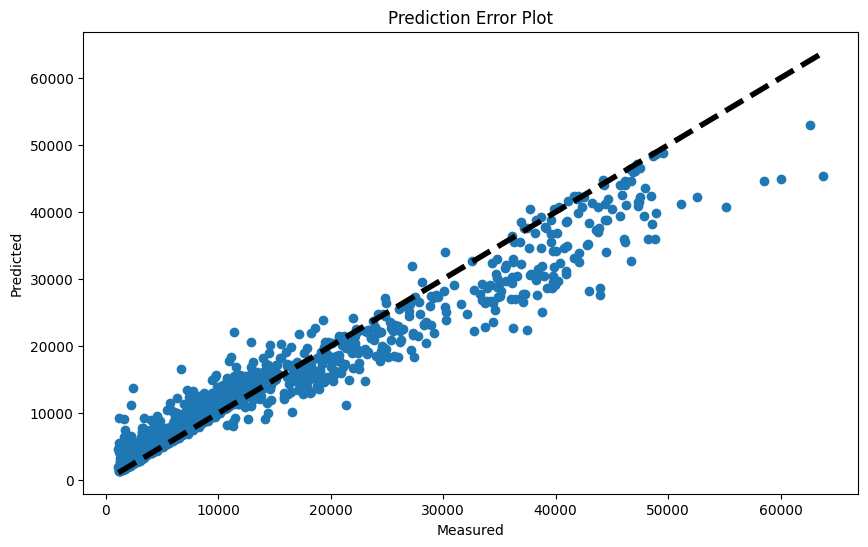

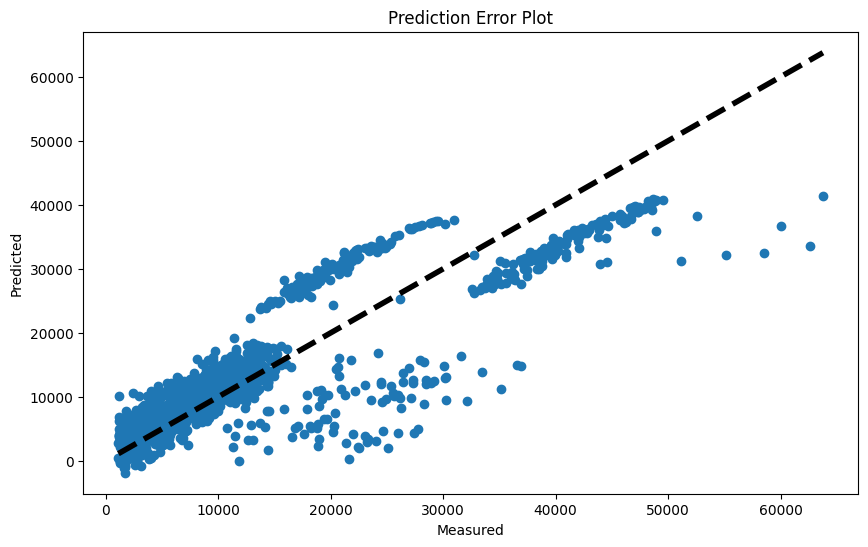

In [9]:
def plot_prediction_error(model, X, y):
    predictions = model.predict(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(y, predictions)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Prediction Error Plot')
    plt.show()

plot_prediction_error(grid_rf.best_estimator_, X, y)
plot_prediction_error(grid_lr.best_estimator_, X, y)


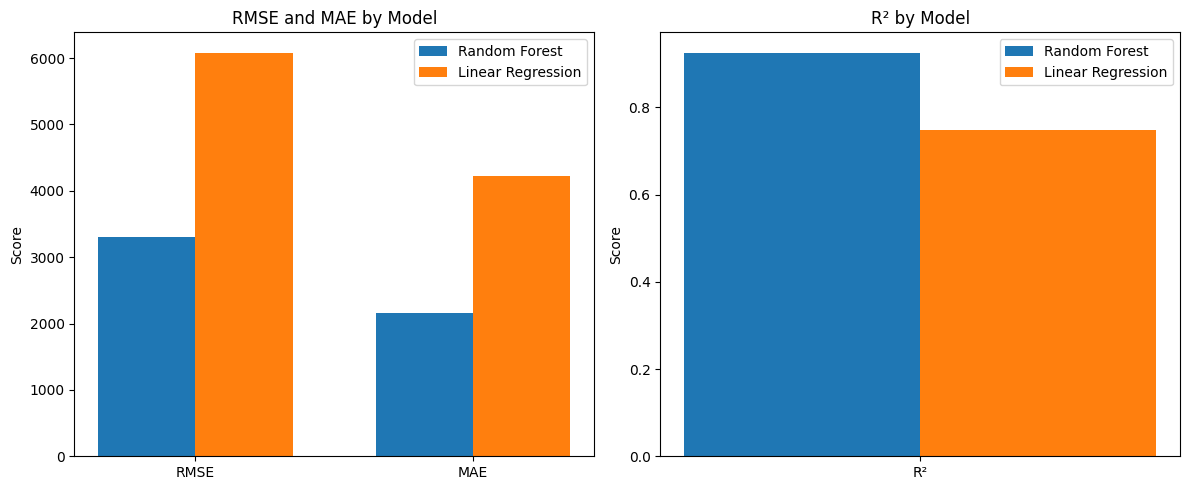

In [10]:
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    return rmse, mae, r2

rmse_rf, mae_rf, r2_rf = evaluate_model(grid_rf.best_estimator_, X, y)
rmse_lr, mae_lr, r2_lr = evaluate_model(grid_lr.best_estimator_, X, y)

width = 0.35
x_rmse_mae = np.arange(2)
x_r2 = np.arange(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(x_rmse_mae - width/2, [rmse_rf, mae_rf], width, label='Random Forest')
ax1.bar(x_rmse_mae + width/2, [rmse_lr, mae_lr], width, label='Linear Regression')
ax1.set_ylabel('Score')
ax1.set_title('RMSE and MAE by Model')
ax1.set_xticks(x_rmse_mae)
ax1.set_xticklabels(['RMSE', 'MAE'])
ax1.legend()

ax2.bar(x_r2 - width/2, [r2_rf], width, label='Random Forest')
ax2.bar(x_r2 + width/2, [r2_lr], width, label='Linear Regression')
ax2.set_ylabel('Score')
ax2.set_title('R² by Model')
ax2.set_xticks(x_r2)
ax2.set_xticklabels(['R²'])
ax2.legend()

fig.tight_layout()
plt.show()
